# Documentation of Eye Gaze Study

**Final Diseases/Classes of interest**
1. Pneumonia - any infection of lungs (bacterial, viral or fungal).
2. CHF (congestive heart failure) - has varying disease severity. Discussions with two radiologists both think this will be really interesting to focus on
3. Normals - good to have for the other class. No chest disease related ICD discharge diagnosis and no abnormal findings from NLP analysis the associated CXR report.

**Research question:** Given CXR ordered in the ED context, can an AI algorithm read better if trained to focus in the clinically relevant anatomical regions with experienced radiologists eye gaze guidance?

**Clinical background:** The 3 types of CXR read clinical outcomes (diagnoses) chosen are bread and butter very common ED presentations. CXR, being quick and relatively inexpensive, is often the first screening imaging exam ordered to guide subsequent diagnosis and treatment. With pneumonia and CHF, patients  commonly present with shortness of breath (SOB) as one of their symptoms. SOB by itself is very non-specific for diagnosis. However, together with other symptoms, patient clinical history and the CXR information, the proper diagnosis can be reached and patient can be given the appropriate treatment.

**Inclusion criteria:**
1. BodyPartExamined LIKE '%CHEST%' (already applied in sql)
2. BurnedInAnnotation LIKE 'NO' (already applied in sql)
3. CXR study_id can be matched to an ED stay_id (cxr.StudyDateTime BETWEEN ed.intime AND ed.outtime) (already applied in sql)
4. First ED admission (edstay_seq == 1)
5. ViewPosition LIKE "PA" -- i.e. PA view images only
6. Have chf or pneumonia in ED diagnosis (via ICD-9 code on discharge for the ED stay), or have normal cxr report and no lung/heart related ED diagnosis (filtered by ICD-9 code)
7. Unique subjects
8. Patient age range: 20 upwards
9. Patient gender: 50:50

**Exclusion criteria:**
1. Overlapping diagnoses (e.g. pneumonia & chf both in ED dx)
2. Patient admitted to ICU (too sick possibly too difficult, bad quality imaging (portables))
3. No lateral images included for this pilot project since can only view 1 image at a time

# Setups

In [ ]:
# Required files
import os
import sys
import pandas as pd
import pandas_gbq
import re

# Connect colab with google bigquery stuff
from google.colab import auth
from google.cloud import bigquery
from google.colab import files
from google.colab import drive

### Authentications

In [ ]:
auth.authenticate_user()

In [ ]:
# Required to read from and write to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify your own project_id on Google Cloud
project_id='mimic-projects'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

### Required MIMIC derived tables

You will need to get access to the following Eye Gaze project related derived tables to run this notebook.
1. eye_gaze.cxr2ed_admit (from colab notebook 1.)
2. eye_gaze.mimic_chexpert_labels (Labels derived from CXR reports using the CheXpert pipeline)
3. eye_gaze.mimic_labeled_dataset (Labels derived from CXR reports using an internal NLP pipeline)

The final sampled master sheet for the Eye Gaze dataset has been committed to the open source reporsitory via PhysioNet.

# Selecting patients with ED meta data

In [ ]:
# Joy is working/playing with this in BQ
sql = """
SELECT * FROM `mimic-projects.eye_gaze.cxr2ed_admit`
"""

data = pandas_gbq.read_gbq(sql, project_id=project_id, dialect = 'standard')
print(data.shape)

(147808, 59)


In [ ]:
data.head()

,dicom_id,path,study_id,patient_id,StudyDate,StudyTime,StudyDateTime,cxrdate,ViewPosition,RequestedProcedureDescription,RequestedProcedurePriority,ExposedArea,PatientOrientation,Modality,BodyPartExamined,WindowCenter,WindowWidth,RescaleIntercept,Rescaleslope,RescaleType,BurnedInAnnotation,subject_id,stay_id,intime,outtime,sex,dx1,dx1_icd,dx2,dx2_icd,dx3,dx3_icd,dx4,dx4_icd,dx5,dx5_icd,dx6,dx6_icd,dx7,dx7_icd,dx8,dx8_icd,dx9,dx9_icd,edstay_seq,indate,outdate,gender,anchor_age,anchor_year,anchor_year_shifted,dod,normal_reports,exclude_normal_cxr,Normal,CHF,pneumonia,copd,sob
0,02c7a055-3d83ba05-2627244b-0adc55eb-e07754cd,files/p10/p10039272/s50384423/02c7a055-3d83ba0...,50384423,10039272,21360309,112440.031,2136-03-09 11:24:40+00:00,2136-03-09 00:00:00+00:00,PA,None,None,"[42, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10039272,30440191,2136-03-09 10:16:00+00:00,2136-03-09 10:22:00+00:00,M,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5,2136-03-09 00:00:00+00:00,2136-03-09 00:00:00+00:00,M,> 80,2012,2131,NaT,0,0,0,0,0,0,0
1,bb764795-2c85098d-6c05f57f-2a884702-a9ca41da,files/p10/p10039272/s50384423/bb764795-2c85098...,50384423,10039272,21360309,112440.031,2136-03-09 11:24:40+00:00,2136-03-09 00:00:00+00:00,LATERAL,None,None,"[42, 35]","['A', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10039272,30440191,2136-03-09 10:16:00+00:00,2136-03-09 10:22:00+00:00,M,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,5,2136-03-09 00:00:00+00:00,2136-03-09 00:00:00+00:00,M,> 80,2012,2131,NaT,0,0,0,0,0,0,0
2,2ba60b60-19b1de98-238969af-47dcb3a3-1835ec98,files/p10/p10101795/s54300643/2ba60b60-19b1de9...,54300643,10101795,21780119,032810.281,2178-01-19 03:28:10+00:00,2178-01-19 00:00:00+00:00,LATERAL,None,None,"[40, 35]","['A', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10101795,31773965,2178-01-19 00:48:00+00:00,2178-01-19 01:11:00+00:00,M,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,29,2178-01-19 00:00:00+00:00,2178-01-19 00:00:00+00:00,M,10 - 20,2009,2170,NaT,1,0,1,0,0,0,0
3,492dd99a-e6135502-19ae894a-aa40309d-4640dc79,files/p10/p10101795/s54300643/492dd99a-e613550...,54300643,10101795,21780119,032810.281,2178-01-19 03:28:10+00:00,2178-01-19 00:00:00+00:00,LATERAL,None,None,"[42, 35]","['A', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10101795,31773965,2178-01-19 00:48:00+00:00,2178-01-19 01:11:00+00:00,M,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,29,2178-01-19 00:00:00+00:00,2178-01-19 00:00:00+00:00,M,10 - 20,2009,2170,NaT,1,0,1,0,0,0,0
4,57994206-2975909d-44f8c9d2-723e4a68-9433ec24,files/p10/p10101795/s54300643/57994206-2975909...,54300643,10101795,21780119,032810.281,2178-01-19 03:28:10+00:00,2178-01-19 00:00:00+00:00,PA,None,None,"[42, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10101795,31773965,2178-01-19 00:48:00+00:00,2178-01-19 01:11:00+00:00,M,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,29,2178-01-19 00:00:00+00:00,2178-01-19 00:00:00+00:00,M,10 - 20,2009,2170,NaT,1,0,1,0,0,0,0


# Exploratory analysis

---



In [ ]:
print('Number of CHF dicoms', data['CHF'].sum())
print('Number of pneumonia dicoms', data['pneumonia'].sum())
print('Number of normal dicoms', data['normal_reports'].sum())
print('Number of normal dicoms', data['Normal'].sum())

Number of CHF dicoms 5456
Number of pneumonia dicoms 9018
Number of normal dicoms 52893
Number of normal dicoms 49262


In [ ]:
print('Number of unique CHF exams', len(set(data[data['CHF']==1].study_id)))
print('Number of unique pneumonia exams', len(set(data[data['pneumonia']==1].study_id)))
print('Number of unique normal exams', len(set(data[data['normal_reports']==1].study_id)))
print('Number of unique normal exams', len(set(data[data['Normal']==1].study_id)))

Number of unique CHF exams 2616
Number of unique pneumonia exams 4374
Number of unique normal exams 24906
Number of unique normal exams 23212


In [ ]:
data[['study_id','sex']].drop_duplicates()['sex'].describe()

count     70457
unique        2
top           F
freq      37617
Name: sex, dtype: object

In [ ]:
data[['study_id','anchor_age']].drop_duplicates()['anchor_age'].describe()

count       70457
unique          9
top       50 - 60
freq        14139
Name: anchor_age, dtype: object

In [ ]:
print('Number of unique subject_ids: ', len(set(data.subject_id)))

Number of unique subject_ids:  43408


In [ ]:
print('Number of unique stay_ids: ', len(set(data.stay_id)))

Number of unique stay_ids:  70273


# Apply inclusion/exclusion criteria for images that quality for pilot dataset


In [ ]:
# Inclusion criteria 4 & 5 & 7
print(data.shape)
pilot = data[(data['edstay_seq'] == 1)&(data.ViewPosition == 'PA')].reset_index(drop = True).copy()
print(pilot.shape)

(147808, 59)
(27031, 59)


In [ ]:
# Inclusion criterion 6
pilot = pilot[(pilot['CHF']==1)|(pilot['pneumonia']==1)|(pilot['Normal']==1)].reset_index(drop = True).copy()
print(pilot.shape)

(13713, 59)


In [ ]:
# Exclusion criteria 1
excludeIDs1 = pilot[(pilot['CHF']==1)&(pilot['pneumonia']==1)].dicom_id.tolist()
print(len(excludeIDs1))
excludeIDs2 = set(pilot[pilot['Normal']==1].dicom_id).intersection(set(pilot[pilot['CHF']==1].dicom_id).union(set(pilot[pilot['pneumonia']==1].dicom_id)).union(set(pilot[pilot['copd']==1].dicom_id)))
print(len(excludeIDs2))


26
15


In [ ]:
# Exclusion criteria 1 continue.
pilot = pilot[~pilot['dicom_id'].isin(excludeIDs1)].reset_index(drop = True).copy()
print(pilot.shape)

pilot = pilot[~pilot['dicom_id'].isin(excludeIDs2)].reset_index(drop = True).copy()
print(pilot.shape)

(13687, 59)
(13672, 59)


In [ ]:
print('Number of CHF dicoms', pilot['CHF'].sum())
print('Number of pneumonia dicoms', pilot['pneumonia'].sum())
print('Number of normal dicoms', pilot['normal_reports'].sum())
print('Number of normal dicoms', pilot['Normal'].sum())
print()
print('Number of unique CHF exams', len(set(pilot[pilot['CHF']==1].study_id)))
print('Number of unique pneumonia exams', len(set(pilot[pilot['pneumonia']==1].study_id)))
print('Number of unique normal exams', len(set(pilot[pilot['normal_reports']==1].study_id)))
print('Number of unique normal exams', len(set(pilot[pilot['Normal']==1].study_id)))
print()
print('Number of unique CHF subjects', len(set(pilot[pilot['CHF']==1].subject_id)))
print('Number of unique pneumonia subjects', len(set(pilot[pilot['pneumonia']==1].subject_id)))
print('Number of unique normal subjects', len(set(pilot[pilot['normal_reports']==1].subject_id)))
print('Number of unique normal subjects', len(set(pilot[pilot['Normal']==1].subject_id)))

Number of CHF dicoms 495
Number of pneumonia dicoms 1392
Number of normal dicoms 11871
Number of normal dicoms 11785

Number of unique CHF exams 437
Number of unique pneumonia exams 1237
Number of unique normal exams 10558
Number of unique normal exams 10482

Number of unique CHF subjects 436
Number of unique pneumonia subjects 1232
Number of unique normal subjects 10554
Number of unique normal subjects 10478


# Exporting all CXR "data" that would qualify for the pilot study

In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.pilot_all'

# #Uncomment to save the table in your bigquery project
# pandas_gbq.to_gbq(pilot, table_id, project_id=project_id)

# Still need to do a bit more exploratory analysis of this dataset to select the final 1000 for pilot eye gaze study

1it [00:00,  1.10it/s]


# Read pilot_all back in with the NLP derived "finding" labels left joined to the dataset, then export results

In [ ]:
# Read this table back in, so we can skip all prior cells in this notebook to run the remaining cells

sql = """
WITH

pilot AS (
SELECT p.*
, lab.rad_id, lab.consensus_labels
, lab.consolidation, lab.enlarged_cardiac_silhouette, lab.linear__patchy_atelectasis, lab.lobar__segmental_collapse
, lab.not_otherwise_specified_opacity___pleural__parenchymal_opacity__, lab.pleural_effusion_or_thickening, lab.pulmonary_edema__hazy_opacity
, lab.normal_anatomically, lab.elevated_hemidiaphragm, lab.hyperaeration, lab.vascular_redistribution
, chx.atelectasis__chx, chx.cardiomegaly__chx, chx.consolidation__chx, chx.edema__chx, chx.enlarged_cardiomediastinum__chx
, chx.fracture__chx, chx.lung_lesion__chx, chx.lung_opacity__chx, chx.no_finding__chx
, chx.pleural_effusion__chx, chx.pleural_other__chx, chx.pneumonia__chx, chx.pneumothorax__chx, chx.support_devices__chx
FROM `mimic-projects.eye_gaze.pilot_all` AS p
LEFT JOIN `mimic-projects.eye_gaze.mimic_labeled_dataset` AS lab
ON p.dicom_id = lab.dicom_id
LEFT JOIN `mimic-projects.eye_gaze.mimic_chexpert_labels` AS chx
ON p.study_id = chx.study_id
--p.study_id = CAST(lab.rad_id AS INT64) -- does same thing

-- Somehow BQ turned the integers in the IDs to floats so can't easily match on these. match on dicom alone should be enough.
--AND p.subject_id = lab.subject_id 
--AND p.study_id = lab.rad_id 
)

SELECT DISTINCT * FROM pilot
"""

pilot = pandas_gbq.read_gbq(sql, project_id=project_id, dialect = 'standard')
print(pilot.shape)

(13672, 86)


In [ ]:
pilot[~pilot['rad_id'].isnull()].head()

,dicom_id,path,study_id,patient_id,StudyDate,StudyTime,StudyDateTime,cxrdate,ViewPosition,RequestedProcedureDescription,RequestedProcedurePriority,ExposedArea,PatientOrientation,Modality,BodyPartExamined,WindowCenter,WindowWidth,RescaleIntercept,Rescaleslope,RescaleType,BurnedInAnnotation,subject_id,stay_id,intime,outtime,sex,dx1,dx1_icd,dx2,dx2_icd,dx3,dx3_icd,dx4,dx4_icd,dx5,dx5_icd,dx6,dx6_icd,dx7,dx7_icd,...,outdate,gender,anchor_age,anchor_year,anchor_year_shifted,dod,normal_reports,exclude_normal_cxr,Normal,CHF,pneumonia,copd,sob,rad_id,consensus_labels,consolidation,enlarged_cardiac_silhouette,linear__patchy_atelectasis,lobar__segmental_collapse,not_otherwise_specified_opacity___pleural__parenchymal_opacity__,pleural_effusion_or_thickening,pulmonary_edema__hazy_opacity,normal_anatomically,elevated_hemidiaphragm,hyperaeration,vascular_redistribution,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
0,c1a49619-f4cf6014-f8026fd3-d618e48f-49e560cd,files/p13/p13415856/s51646064/c1a49619-f4cf601...,51646064,13415856,21840909,154518.281,2184-09-09 15:45:18+00:00,2184-09-09 00:00:00+00:00,PA,None,None,"[42, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,13415856,35749259,2184-09-09 11:47:00+00:00,2184-09-09 11:54:00+00:00,F,"CONGESTIVE HEART FAILURE, UNSPEC",428.0,HYPERTENSION NOS,401.9,LONG TERM USE ANTIGOAGULANT,V58.61,None,None,None,None,None,None,None,None,...,2184-09-09 00:00:00+00:00,F,70 - 80,1998,2169,NaT,0,0,0,1,0,0,0,51646064.0,anatomicalfinding|yes|spinal fracture&&anatomi...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,-1.0,NaN,NaN
1,53491a56-89dcfdd4-a0a0e8d5-ae5492b1-933aa7ec,files/p16/p16111436/s55108725/53491a56-89dcfdd...,55108725,16111436,21370322,211806.359,2137-03-22 21:18:06+00:00,2137-03-22 00:00:00+00:00,PA,None,None,"[42, 34]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,16111436,30832396,2137-03-22 17:15:00+00:00,2137-03-22 17:23:00+00:00,F,PALPITATIONS,785.1,HYPERTENSION NOS,401.9,HYPERLIPIDEMIA NEC/NOS,272.4,None,None,None,None,None,None,None,None,...,2137-03-22 00:00:00+00:00,F,20 - 30,1996,2119,NaT,1,0,1,0,0,0,0,55108725.0,anatomicalfinding|yes|normal anatomically,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,705bfb06-6038ae37-300c104e-f81295ae-09ce3940,files/p16/p16317070/s50693469/705bfb06-6038ae3...,50693469,16317070,21260504,142809.921,2126-05-04 14:28:09+00:00,2126-05-04 00:00:00+00:00,PA,None,None,"[37, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,16317070,34154553,2126-05-04 11:30:00+00:00,2126-05-04 11:47:00+00:00,F,AORTIC VALVE DISORDER,424.1,HEART FAILURE NOS,428.9,OTHER ISCHEMIC HEART DISEASE,411.89,SYNCOPE AND COLLAPSE,780.2,HYPERTENSION NOS,401.9,None,None,None,None,...,2126-05-04 00:00:00+00:00,F,> 80,2011,2125,NaT,1,1,0,1,0,0,0,50693469.0,anatomicalfinding|yes|normal anatomically,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,ca3c1920-8a18e724-85a9e361-3aa9e096-1eb76d57,files/p14/p14354252/s55299289/ca3c1920-8a18e72...,55299289,14354252,21270726,231444.125,2127-07-26 23:14:44+00:00,2127-07-26 00:00:00+00:00,PA,None,None,"[42, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,14354252,39551494,2127-07-26 20:35:00+00:00,2127-07-26 20:45:00+00:00,F,SYNCOPE AND COLLAPSE,780.2,URIN TRACT INFECTION NOS,599.0,ABN LIVER FUNCTION STUDY,794.8,None,None,None,None,None,None,None,None,...,2127-07-26 00:00:00+00:00,F,60 - 70,2002,2116,NaT,1,0,1,0,0,0,0,55299289.0,anatomicalfinding|yes|normal anatomically,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,a29141ef-3ecb0b81-225ef1c3-6bab3f38-960beb26,files/p15/p15164234/s57959815/a29141ef-3ecb0b8...,57959815,15164234,21740815,225630.2

In [ ]:
print(pilot[~pilot['rad_id'].isnull()].shape)

(13657, 86)


In [ ]:
# Some dicoms do not have derived labels (because have no CXR reports) -- hence turned to floats...
pilot[pilot['rad_id'].isnull()]

,dicom_id,path,study_id,patient_id,StudyDate,StudyTime,StudyDateTime,cxrdate,ViewPosition,RequestedProcedureDescription,RequestedProcedurePriority,ExposedArea,PatientOrientation,Modality,BodyPartExamined,WindowCenter,WindowWidth,RescaleIntercept,Rescaleslope,RescaleType,BurnedInAnnotation,subject_id,stay_id,intime,outtime,sex,dx1,dx1_icd,dx2,dx2_icd,dx3,dx3_icd,dx4,dx4_icd,dx5,dx5_icd,dx6,dx6_icd,dx7,dx7_icd,...,outdate,gender,anchor_age,anchor_year,anchor_year_shifted,dod,normal_reports,exclude_normal_cxr,Normal,CHF,pneumonia,copd,sob,rad_id,consensus_labels,consolidation,enlarged_cardiac_silhouette,linear__patchy_atelectasis,lobar__segmental_collapse,not_otherwise_specified_opacity___pleural__parenchymal_opacity__,pleural_effusion_or_thickening,pulmonary_edema__hazy_opacity,normal_anatomically,elevated_hemidiaphragm,hyperaeration,vascular_redistribution,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
140,f60f8583-d5b2a894-fe8f0ca8-4e08b2d1-e05034e2,files/p11/p11894220/s51654664/f60f8583-d5b2a89...,51654664,11894220,22000612,230426.703,2200-06-12 23:04:26+00:00,2200-06-12 00:00:00+00:00,PA,None,None,"[33, 33]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,11894220,34490436,2200-06-12 22:02:00+00:00,2200-06-12 22:46:00+00:00,M,"PNEUMONIA,ORGANISM UNSPECIFIED",486,HYPERTENSION NOS,401.9,HYPERCHOLESTEROLEMIA,272.0,None,None,None,None,None,None,None,None,...,2200-06-12 00:00:00+00:00,M,70 - 80,1999,2185,NaT,0,1,0,0,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN
865,6fa7bce5-abb6a41f-4a101710-6e6be55a-556e5c0d,files/p15/p15017475/s50240024/6fa7bce5-abb6a41...,50240024,15017475,21800718,110540.125,2180-07-18 11:05:40+00:00,2180-07-18 00:00:00+00:00,PA,None,None,"[39, 34]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,15017475,37395521,2180-07-18 10:11:00+00:00,2180-07-18 10:17:00+00:00,F,"PNEUMONIA,ORGANISM UNSPECIFIED",486,None,None,None,None,None,None,None,None,None,None,None,None,...,2180-07-18 00:00:00+00:00,F,30 - 40,1996,2163,NaT,0,1,0,0,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,NaN
955,e8c44f7c-a1b2c04f-687932d3-dbe7939f-1def5464,files/p17/p17419788/s53977524/e8c44f7c-a1b2c04...,53977524,17419788,21740228,145346.000,2174-02-28 14:53:46+00:00,2174-02-28 00:00:00+00:00,PA,CHEST (PA AND LAT),None,None,"['L', 'F']",DX,CHEST,"['5473', '5473', '5473']","['3455', '2591', '5183']",0.0,1.0,US,NO,17419788,39060488,2174-02-28 00:05:00+00:00,2174-02-28 08:07:00+00:00,M,DIAB KETOACIDOSIS IDDM,250.11,"PNEUMONIA,ORGANISM UNSPECIFIED",486,None,None,None,None,None,None,None,None,None,None,...,2174-02-28 00:00:00+00:00,M,40 - 50,2014,2173,NaT,0,1,0,0,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,f5d6845f-07455d54-d4b16fee-1c05d8ae-6bd0529b,files/p19/p19480385/s56037089/f5d6845f-07455d5...,56037089,19480385,21491211,210653.546,2149-12-11 21:06:53+00:00,2149-12-11 00:00:00+00:00,PA,None,None,"[37, 34]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,19480385,36690664,2149-12-11 19:16:00+00:00,2149-12-12 00:35:00+00:00,F,"PNEUMONIA,ORGANISM UNSPECIFIED",486,None,None,None,None,None,None,None,None,None,None,None,None,...,2149-12-12 00:00:00+00:00,F,40 - 50,2008,2143,NaT,0,1,0,0,1,0,0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3004,0e0172bd-6f7886b8-daf4e38c-50acc113-80b464c2,files/p13/p13527612/s51192929/0e0172bd-6f7886b...,51192929,13527612,21380918,060833.171,2138-09-18 06:08:33+00:00,2138-09-18 00:00:00+00:00,PA,None,None,"[40, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,13527612,36284546,2138-09-18 05:47:00+00:00,2138-09-18 06:55:00+00:00,M,CHEST PAIN NOS,7

In [ ]:
# minimal lost
print('Lost studies from not having report labels: ', len(set(pilot[pilot['rad_id'].isnull()].study_id)))
print('Lost images from not having report labels: ', len(set(pilot[pilot['rad_id'].isnull()].path)))

Lost studies from not having report labels:  15
Lost images from not having report labels:  15


In [ ]:
pilot['Female'] = [1 if x == 'F' else 0 for x in pilot['gender']]

In [ ]:
# intcols = ['rad_id', 'consolidation', 'elevated_hemidiaphragm', 'enlarged_cardiac_silhouette', 'hyperaeration', 'linear__patchy_atelectasis', 'lobar__segmental_collapse', 'normal_anatomically', 'not_otherwise_specified_opacity___pleural__parenchymal_opacity__', 'pleural_effusion_or_thickening', 'pulmonary_edema__hazy_opacity', 'vascular_redistribution']
# for col in intcols:
#     pilot[col] = [int(x) for x in pilot[col]]
# print('done')
# pilot.head()

# Missing numbers but lets keep these cases for testing not training so we don't lose samples.

In [ ]:
print(pilot.columns.tolist())
print(pilot.shape)

['dicom_id', 'path', 'study_id', 'patient_id', 'StudyDate', 'StudyTime', 'StudyDateTime', 'cxrdate', 'ViewPosition', 'RequestedProcedureDescription', 'RequestedProcedurePriority', 'ExposedArea', 'PatientOrientation', 'Modality', 'BodyPartExamined', 'WindowCenter', 'WindowWidth', 'RescaleIntercept', 'Rescaleslope', 'RescaleType', 'BurnedInAnnotation', 'subject_id', 'stay_id', 'intime', 'outtime', 'sex', 'dx1', 'dx1_icd', 'dx2', 'dx2_icd', 'dx3', 'dx3_icd', 'dx4', 'dx4_icd', 'dx5', 'dx5_icd', 'dx6', 'dx6_icd', 'dx7', 'dx7_icd', 'dx8', 'dx8_icd', 'dx9', 'dx9_icd', 'edstay_seq', 'indate', 'outdate', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_shifted', 'dod', 'normal_reports', 'exclude_normal_cxr', 'Normal', 'CHF', 'pneumonia', 'copd', 'sob', 'rad_id', 'consensus_labels', 'consolidation', 'enlarged_cardiac_silhouette', 'linear__patchy_atelectasis', 'lobar__segmental_collapse', 'not_otherwise_specified_opacity___pleural__parenchymal_opacity__', 'pleural_effusion_or_thickening', 'pul

In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.pilot_all_labeled'
project_id='mimic-projects'

# pandas_gbq.to_gbq(pilot, table_id, project_id=project_id)

1it [00:01,  1.19s/it]


In [ ]:
# pilot all dataset stats
sql="""
SELECT  
count(distinct subject_id) as patients
,count(distinct stay_id) as ed_stays
,count(distinct study_id) as cxr_studies
FROM `mimic-projects.eye_gaze.pilot_all_labeled`
WHERE anchor_age NOT LIKE "0 - 10"
AND anchor_age NOT LIKE "10 - 20"
AND ViewPosition LIKE "PA"
--AND pneumonia = 1
--AND CHF = 1
--AND Normal = 1
"""
df = pandas_gbq.read_gbq(sql, project_id=project_id, dialect = 'standard')
df

,patients,ed_stays,cxr_studies
0,11275,11275,11284


In [ ]:
# stats for final images sampled for the eye gaze dataset
sql = """
SELECT  
count(distinct patient_id) as patients
,count(distinct stay_id) as ed_stays
,count(distinct study_id) as cxr_studies
,count(distinct dicom_id) as images
FROM `mimic-projects.eye_gaze.eye_gaze_master`
WHERE anchor_age NOT LIKE "0 - 10"
AND anchor_age NOT LIKE "10 - 20"
AND ViewPosition LIKE "PA"
--AND pneumonia = 1
--AND CHF = 1
AND Normal = 1
"""
df = pandas_gbq.read_gbq(sql, project_id=project_id, dialect = 'standard')
df

,patients,ed_stays,cxr_studies,images
0,359,359,359,360


# Exploratory analysis of sex and age groups of the 3 classes of interest

In [ ]:
# Read this table back in, so we can skip all prior cells in this notebook to run the remaining cells

sql = """
SELECT * FROM `mimic-projects.eye_gaze.pilot_all_labeled`
"""

pilot = pandas_gbq.read_gbq(sql, project_id=project_id, dialect = 'standard')
print(pilot.shape)

(13672, 87)


In [ ]:
noreps =pilot[pilot['rad_id'].isnull()].reset_index(drop=True).copy()
print(noreps.shape)

(15, 87)


In [ ]:
print('Number of CHF dicoms', noreps['CHF'].sum())
print('Number of pneumonia dicoms', noreps['pneumonia'].sum())
print('Number of normal dicoms', noreps['normal_reports'].sum())
print('Number of normal dicoms', noreps['Normal'].sum())

Number of CHF dicoms 2
Number of pneumonia dicoms 13
Number of normal dicoms 0
Number of normal dicoms 0


In [ ]:
# dicoms to exclude
for dicom in noreps.dicom_id.tolist():  
    print(dicom)

0e05713f-85d4a485-25e187c0-033759d0-90d83d60
0e0172bd-6f7886b8-daf4e38c-50acc113-80b464c2
4731cd31-9bb72171-7f3ecce9-085e0f1f-0d22f321
6fa7bce5-abb6a41f-4a101710-6e6be55a-556e5c0d
f5d6845f-07455d54-d4b16fee-1c05d8ae-6bd0529b
d5db0653-ebcc2c96-24ea65b5-fd1ea115-59d9f306
278e02b9-938c6af5-ebcf853a-2cd0973a-d138219b
e8c44f7c-a1b2c04f-687932d3-dbe7939f-1def5464
740d74ac-30f5cd7c-4c22501c-e6074db3-503b1cae
a91306ad-d0020719-26ac2e73-c00f1b3c-7a6e269c
0647e7d5-77d53f05-102ff257-3a860cbc-2fb58260
9e19dfef-5d5e6d0b-0ce6cca6-269c249e-0e14d88b
0c78fb79-19c587f4-0ee03dd3-bce1c96a-3331345e
be724e0f-47b25ba9-949e542f-12dbaa3d-ddb0b0fc
f60f8583-d5b2a894-fe8f0ca8-4e08b2d1-e05034e2


In [ ]:
# Exclude the 15 rows where there are no CXR reports that match the dicom_id
pilot = pilot[~pilot['rad_id'].isnull()].reset_index(drop=True).copy()

In [ ]:
pilot.head()

,dicom_id,path,study_id,patient_id,StudyDate,StudyTime,StudyDateTime,cxrdate,ViewPosition,RequestedProcedureDescription,RequestedProcedurePriority,ExposedArea,PatientOrientation,Modality,BodyPartExamined,WindowCenter,WindowWidth,RescaleIntercept,Rescaleslope,RescaleType,BurnedInAnnotation,subject_id,stay_id,intime,outtime,sex,dx1,dx1_icd,dx2,dx2_icd,dx3,dx3_icd,dx4,dx4_icd,dx5,dx5_icd,dx6,dx6_icd,dx7,dx7_icd,...,gender,anchor_age,anchor_year,anchor_year_shifted,dod,normal_reports,exclude_normal_cxr,Normal,CHF,pneumonia,copd,sob,rad_id,consensus_labels,consolidation,enlarged_cardiac_silhouette,linear__patchy_atelectasis,lobar__segmental_collapse,not_otherwise_specified_opacity___pleural__parenchymal_opacity__,pleural_effusion_or_thickening,pulmonary_edema__hazy_opacity,normal_anatomically,elevated_hemidiaphragm,hyperaeration,vascular_redistribution,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx,Female
0,3e183402-7160eee2-17df4124-7d4eb8b0-d36e57f3,files/p17/p17738963/s51019705/3e183402-7160eee...,51019705,17738963,21240108,134028.515,2124-01-08 13:40:28+00:00,2124-01-08 00:00:00+00:00,PA,None,None,"[42, 35]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,17738963,38110073,2124-01-08 11:36:00+00:00,2124-01-08 11:57:00+00:00,F,"PNEUMONIA,ORGANISM UNSPECIFIED",486,None,None,None,None,None,None,None,None,None,None,None,None,...,F,0 - 10,2004,2116,NaT,0,1,0,0,1,0,0,51019705.0,technicalassessment|yes|low lung volumes&&anat...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0,0.0,NaN,1
1,80da4863-c8872dec-d4512881-2ac06af3-ed30969d,files/p10/p10556898/s53436103/80da4863-c8872de...,53436103,10556898,21431016,194554.546,2143-10-16 19:45:54+00:00,2143-10-16 00:00:00+00:00,PA,None,None,"[34, 33]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,10556898,30898648,2143-10-16 15:56:00+00:00,2143-10-16 16:12:00+00:00,F,"Oth pregnancy related conditions, first trimester",O26.891,"Chest pain, unspecified",R07.9,Less than 8 weeks gestation of pregnancy,Z3A.01,None,None,None,None,None,None,None,None,...,F,0 - 10,2001,2127,NaT,1,0,1,0,0,0,0,53436103.0,anatomicalfinding|yes|normal anatomically,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1
2,64b1542f-fa76d8d5-41728563-5b911680-ecd19e58,files/p15/p15403967/s51938741/64b1542f-fa76d8d...,51938741,15403967,21771118,145220.390,2177-11-18 14:52:20+00:00,2177-11-18 00:00:00+00:00,PA,None,None,"[41, 34]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,15403967,35141888,2177-11-18 13:08:00+00:00,2177-11-18 13:13:00+00:00,F,"ASTHMA, UNSPECIFIED",493.90,WHEEZING,786.07,BRONCHITIS,490,None,None,None,None,None,None,None,None,...,F,0 - 10,1997,2161,NaT,1,0,1,0,0,0,0,51938741.0,anatomicalfinding|yes|normal anatomically&&ana...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1
3,e0ec007b-8bd7bed2-797c5b17-c1050b49-3d65ec29,files/p15/p15403967/s51938741/e0ec007b-8bd7bed...,51938741,15403967,21771118,145220.390,2177-11-18 14:52:20+00:00,2177-11-18 00:00:00+00:00,PA,None,None,"[41, 34]","['R', 'F']",DX,CHEST,2048,4096,0.0,1.0,US,NO,15403967,35141888,2177-11-18 13:08:00+00:00,2177-11-18 13:13:00+00:00,F,"ASTHMA, UNSPECIFIED",493.90,WHEEZING,786.07,BRONCHITIS,490,None,None,None,None,None,None,None,None,...,F,0 - 10,1997,2161,NaT,1,0,1,0,0,0,0,51938741.0,anatomicalfinding|yes|normal anatomically&&ana...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1
4,1a9036a7-f6645d14-6f93c905-041a858f-745ca82a,files/p13/p13469377/s59385067/1a9036a7-f6645d1...,59385067,13469377,21500122,083752.000,2150-01-22 08:37:52+00:00,2150-01-22 00:00:00+00:00,PA,CHEST (PA AND LAT),None,None,"['L', 'F']",DX,CHEST,"['5127', '5127', '5127']","['3147

In [ ]:
# Class 1: CHF (CHF is from the ED d/c diagnosis ground truth)

chf = pilot[(pilot['CHF']==1)&(pilot['edstay_seq'] == 1)].reset_index(drop=True).copy()
print(chf.shape)
#chf_count= chf.groupby(['anchor_age']).size().reset_index(name='counts')
chf_count= chf.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
chf_sum=sum(chf_count.counts)
chf_count['chf'] = chf_count.counts / chf_sum
chf_count

(493, 87)


,anchor_age,Female,counts,chf
0,10 - 20,0,1,0.002028
1,20 - 30,0,8,0.016227
2,20 - 30,1,4,0.008114
3,30 - 40,0,17,0.034483
4,30 - 40,1,3,0.006085
5,40 - 50,0,47,0.095335
6,40 - 50,1,18,0.036511
7,50 - 60,0,76,0.154158
8,50 - 60,1,27,0.054767
9,60 - 70,0,69,0.139959


In [ ]:
## Class 1 plus related CXR findings

edema = pilot[pilot['edstay_seq'] == 1].reset_index(drop=True).copy()

# Report derived labels
edema = edema[(edema['edema__chx']==1)|(edema['pleural_effusion__chx'] == 1)|(edema['cardiomegaly__chx'])|(edema['enlarged_cardiomediastinum__chx'])].reset_index(drop=True).copy()

# D/c diagnosis derived label
edema = edema[edema['CHF'] == 1].reset_index(drop=True).copy()

print(edema.shape)
#chf_count= chf.groupby(['anchor_age']).size().reset_index(name='counts')
edema_count= edema.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
edema_sum=sum(edema_count.counts)
edema_count['edema'] = edema_count.counts / edema_sum
edema_count

(353, 87)


,anchor_age,Female,counts,edema
0,10 - 20,0,1,0.002833
1,20 - 30,0,7,0.019830
2,20 - 30,1,3,0.008499
3,30 - 40,0,15,0.042493
4,30 - 40,1,2,0.005666
5,40 - 50,0,33,0.093484
6,40 - 50,1,10,0.028329
7,50 - 60,0,60,0.169972
8,50 - 60,1,21,0.059490
9,60 - 70,0,52,0.147309


In [ ]:
# Check overlap with different discharge diagnosis derived label (pneumonia)
chf_pna = edema[edema['pneumonia'] == 1].reset_index(drop=True).copy()
print(chf_pna.shape)

chf_pna_count= chf_pna.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
chf_pna_sum=sum(chf_pna_count.counts)
chf_pna_count['chf_pna'] = chf_pna_count.counts / chf_pna_sum
chf_pna_count

(0, 87)


,anchor_age,Female,counts,chf_pna


In [ ]:
## Class 2: pneumonia


# Discharge diagnosis from ED
pna = pilot[(pilot['pneumonia']==1)&(pilot['edstay_seq'] == 1)].reset_index(drop=True).copy()
print(pna.shape)

#pna_count= pna.groupby(['anchor_age']).size().reset_index(name='counts')
pna_count= pna.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
pna_sum=sum(pna_count.counts)
pna_count['pneumonia'] = pna_count.counts / pna_sum
pna_count

(1379, 87)


,anchor_age,Female,counts,pneumonia
0,0 - 10,1,1,0.000725
1,10 - 20,0,43,0.031182
2,10 - 20,1,25,0.018129
3,20 - 30,0,93,0.067440
4,20 - 30,1,98,0.071066
5,30 - 40,0,106,0.076867
6,30 - 40,1,77,0.055838
7,40 - 50,0,102,0.073967
8,40 - 50,1,98,0.071066
9,50 - 60,0,151,0.109500


In [ ]:
## Class 2 plus related CXR findings

consol = pilot[pilot['edstay_seq'] == 1].reset_index(drop=True).copy()

## Report derived labels
# Option 1: 
# consol = consol[consol['consolidation__chx']==1].reset_index(drop=True).copy()
# consol = consol[consol['pneumonia__chx']==1].reset_index(drop=True).copy()
# Option 2: use OR with 'lung_opacity__chx' which is a very non-specific opacity related label (which would include opacity related to edema/CHF)
#consol = consol[(consol['consolidation__chx']==1)|(consol['lung_opacity__chx'] == 1)].reset_index(drop=True).copy()
# Option 3: mentioning of pneumonia in report is often hedged/uncertain. e.g. cannot exclude pneumonia.
consol = consol[(consol['consolidation__chx']==1)|(consol['pneumonia__chx'] == 1)].reset_index(drop=True).copy() 

## ED D/c diagnosis derived labels
consol = consol[consol['pneumonia'] == 1].reset_index(drop=True).copy()
print(consol.shape)

#pna_count= pna.groupby(['anchor_age']).size().reset_index(name='counts')
consol_count= consol.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
consol_sum=sum(consol_count.counts)
consol_count['consolidation'] = consol_count.counts / consol_sum
print('including both the finding (consolidation) label and the disease label from reports (pneumonia_chx), there are',sum(consol_count.counts))
consol_count #lower overlap with final discharge diagnosis.

(646, 87)
including both the finding (consolidation) label and the disease label from reports (pneumonia_chx), there are 646


,anchor_age,Female,counts,consolidation
0,0 - 10,1,1,0.001548
1,10 - 20,0,31,0.047988
2,10 - 20,1,18,0.027864
3,20 - 30,0,57,0.088235
4,20 - 30,1,59,0.091331
5,30 - 40,0,58,0.089783
6,30 - 40,1,39,0.060372
7,40 - 50,0,56,0.086687
8,40 - 50,1,44,0.068111
9,50 - 60,0,55,0.085139


In [ ]:
# If using the consolidation finding label from joy's nlp (i have not extracted pneumonia label, but could, from mimic yet)
consol2 = pilot[pilot['edstay_seq'] == 1].reset_index(drop=True).copy()
print(consol2.shape)
# Report derived finding from Joy's pipeline
consol2 = consol2[consol2['consolidation']==1].reset_index(drop=True).copy()
print(consol2.shape)
## ED D/c diagnosis derived labels
consol2 = consol2[consol2['pneumonia']==1].reset_index(drop=True).copy()
print(consol2.shape)

#pna_count= pna.groupby(['anchor_age']).size().reset_index(name='counts')
consol_count2= consol2.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
consol_sum2=sum(consol_count2.counts)
consol_count2['consolidation'] = consol_count2.counts / consol_sum2
print(sum(consol_count2.counts))
consol_count2

(13657, 87)
(501, 87)
(461, 87)
461


,anchor_age,Female,counts,consolidation
0,10 - 20,0,20,0.043384
1,10 - 20,1,12,0.026030
2,20 - 30,0,34,0.073753
3,20 - 30,1,38,0.082430
4,30 - 40,0,47,0.101952
5,30 - 40,1,30,0.065076
6,40 - 50,0,36,0.078091
7,40 - 50,1,37,0.080260
8,50 - 60,0,41,0.088937
9,50 - 60,1,29,0.062907


In [ ]:
# Class 3: Normal (no abnormal finding labels from report & absense of pneumonia/CHF diagnosis from discharge dx)

#norm = pilot[(pilot['normal_reports']==1)&(pilot['edstay_seq'] == 1)].reset_index(drop=True).copy()
norm = pilot[(pilot['Normal']==1)&(pilot['edstay_seq'] == 1)].reset_index(drop=True).copy()
print(norm.shape)
norm = norm[(norm['CHF']==0)&(norm['pneumonia'] == 0)].reset_index(drop=True).copy()
print(norm.shape)

#norm_count= norm.groupby(['anchor_age']).size().reset_index(name='counts')
norm_count= norm.groupby(['anchor_age','Female'])['Female'].size().reset_index(name='counts')
norm_sum=sum(norm_count.counts)
norm_count['normal'] = norm_count.counts / norm_sum
norm_count

(11785, 87)
(11785, 87)


,anchor_age,Female,counts,normal
0,0 - 10,0,27,0.002291
1,0 - 10,1,21,0.001782
2,10 - 20,0,335,0.028426
3,10 - 20,1,497,0.042172
4,20 - 30,0,1461,0.123971
5,20 - 30,1,1567,0.132966
6,30 - 40,0,1181,0.100212
7,30 - 40,1,1156,0.098091
8,40 - 50,0,1172,0.099448
9,40 - 50,1,1119,0.094951


In [ ]:
gender = chf['sex'].describe()

print('CHF male proportion: ', gender['freq']/gender['count'])

CHF male proportion:  0.6348884381338742


In [ ]:
gender = pna['sex'].describe()

print('Pneumonia male proportion: ', gender['freq']/gender['count'])

Pneumonia male proportion:  0.5663524292965917


In [ ]:
gender = norm['sex'].describe()

print('Normal CXR male proportion: ', 1-gender['freq']/gender['count'])

Normal CXR male proportion:  0.49579974543911753


# Analysing overlap between classes

In [ ]:
# There are NO overlapping CXR dicoms across the 3 final ground truth classes

chf_dicoms = set(edema.dicom_id)
pna_dicoms = set(consol.dicom_id)
norm_dicoms = set(norm.dicom_id)

overlapAll = chf_dicoms.intersection(pna_dicoms).intersection(norm_dicoms)

print("Overlap:", len(overlapAll))

Overlap: 0


In [ ]:
reportlabs_all = ['atelectasis__chx', 'cardiomegaly__chx', 'consolidation__chx', 'edema__chx', 'enlarged_cardiomediastinum__chx', 'fracture__chx', 'lung_lesion__chx', 'lung_opacity__chx', 'no_finding__chx', 'pleural_effusion__chx', 'pleural_other__chx', 'pneumonia__chx', 'pneumothorax__chx', 'support_devices__chx']

reportlabs_chf = ['cardiomegaly__chx', 'edema__chx', 'enlarged_cardiomediastinum__chx', 'pleural_effusion__chx']

reportlabs_pna = ['consolidation__chx', 'pneumonia__chx']

print('Report derived labels related to CHF:', reportlabs_chf)
print('Report derived labels related to pneumonia:', reportlabs_pna)

all_labs = reportlabs_chf + reportlabs_pna

Report derived labels related to CHF: ['cardiomegaly__chx', 'edema__chx', 'enlarged_cardiomediastinum__chx', 'pleural_effusion__chx']
Report derived labels related to pneumonia: ['consolidation__chx', 'pneumonia__chx']


In [ ]:
# Label distribution for df: edema 
edema2 = edema.copy()
chf_mean = []
for lab in reportlabs_all:
    edema2[lab] = [1 if x > 0 else 0 for x in edema2[lab]]
    m = edema2[lab].mean()
    chf_mean.append(m)
print(len(chf_mean))

chf_dist = edema2[reportlabs_all].describe()
chf_dist

14


,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.000000
mean,0.169972,0.467422,0.022663,0.450425,0.005666,0.0,0.022663,0.192635,0.0,0.529745,0.008499,0.042493,0.002833,0.025496
std,0.376141,0.499646,0.149038,0.498242,0.075164,0.0,0.149038,0.394928,0.0,0.499823,0.091925,0.201997,0.053225,0.157849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Label distribution for df: consol
consolx = consol.copy()
pna_mean = []
for lab in reportlabs_all:
    consolx[lab] = [1 if x > 0 else 0 for x in consolx[lab]]
    m = consolx[lab].mean()
    pna_mean.append(m)
print(len(pna_mean))

pna_dist = consolx[reportlabs_all].describe()
pna_dist

14


,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.0,646.000000,646.000000,646.000000,646.0,646.000000
mean,0.063467,0.026316,0.196594,0.015480,0.001548,0.003096,0.043344,0.335913,0.0,0.066563,0.007740,0.893189,0.0,0.009288
std,0.243991,0.160197,0.397731,0.123547,0.039344,0.055598,0.203787,0.472675,0.0,0.249458,0.087704,0.309112,0.0,0.096000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000


In [ ]:
# Label distribution for df: consol
normx = norm.copy()
norm_mean = []
for lab in reportlabs_all:
    normx[lab] = [1 if x > 0 else 0 for x in normx[lab]]
    m = normx[lab].mean()
    norm_mean.append(m)
print(len(norm_mean))

norm_dist = normx[reportlabs_all].describe()
norm_dist

14


,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
count,11785.000000,11785.000000,11785.0,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000,11785.000000
mean,0.000255,0.005685,0.0,0.000255,0.002800,0.007637,0.000424,0.002630,0.951718,0.000255,0.000424,0.007722,0.000255,0.006364
std,0.015954,0.075189,0.0,0.015954,0.052845,0.087058,0.020594,0.051223,0.214370,0.015954,0.020594,0.087537,0.015954,0.079524
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Label distribution for df: chf -- no exclusions
chf2 = chf.copy()
chf_mean2 = []
for lab in reportlabs_all:
    chf2[lab] = [1 if x > 0 else 0 for x in chf2[lab]]
    m = chf2[lab].mean()
    chf_mean2.append(m)
print(len(chf_mean2))

chf_dist2 = chf2[reportlabs_all].describe()
chf_dist2

14


,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,0.172414,0.334686,0.026369,0.322515,0.004057,0.002028,0.032454,0.219067,0.081136,0.379310,0.008114,0.058824,0.002028,0.024341
std,0.378123,0.472360,0.160393,0.467914,0.063628,0.045038,0.177383,0.414034,0.273321,0.485708,0.089800,0.235533,0.045038,0.154261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Label distribution for df: pna 
pna2 = pna.copy()
pna_mean2 = []
for lab in reportlabs_all:
    pna2[lab] = [1 if x > 0 else 0 for x in pna2[lab]]
    m = pna2[lab].mean()
    pna_mean2.append(m)
print(len(pna_mean))

pna_dist2 = pna2[reportlabs_all].describe()
pna_dist2

14


,atelectasis__chx,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx
count,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000
mean,0.087020,0.041334,0.092096,0.032632,0.005076,0.004351,0.050036,0.485859,0.086294,0.094271,0.008702,0.418419,0.003626,0.010152
std,0.281966,0.199134,0.289266,0.177737,0.071092,0.065842,0.218099,0.499981,0.280900,0.292312,0.092911,0.493479,0.060127,0.100282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<BarContainer object of 14 artists>

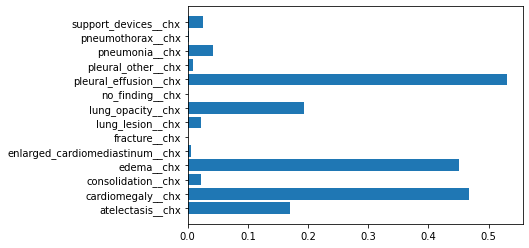

In [ ]:
import matplotlib

# With exclusion by report chexpert labels (from the df: edema)
matplotlib.pyplot.barh(y = reportlabs_all, width = chf_mean)

<BarContainer object of 14 artists>

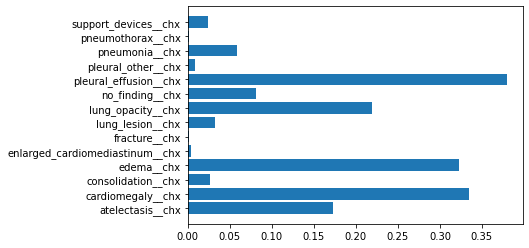

In [ ]:
# Without exclusion (original from the df: chf)
matplotlib.pyplot.barh(y = reportlabs_all, width = chf_mean2)

<BarContainer object of 14 artists>

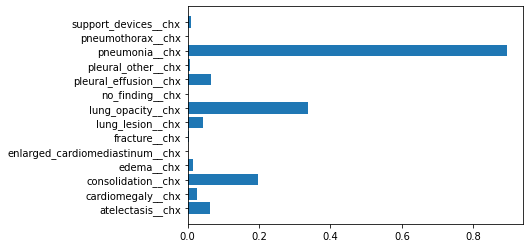

In [ ]:
# With exclusion by report chexpert labels (df: consol)
matplotlib.pyplot.barh(y = reportlabs_all, width = pna_mean)

<BarContainer object of 14 artists>

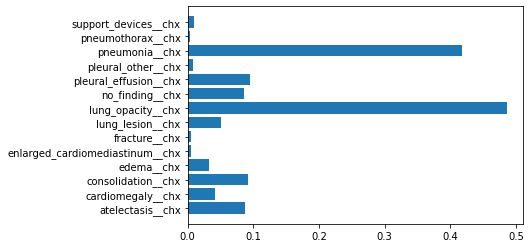

In [ ]:
# Without exclusion (df: pna)
matplotlib.pyplot.barh(y = reportlabs_all, width = pna_mean2)

<BarContainer object of 14 artists>

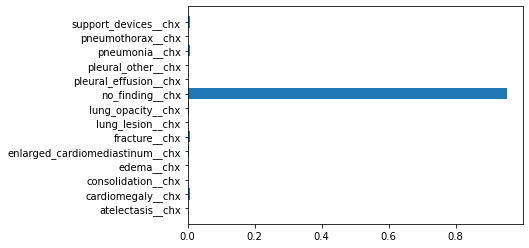

In [ ]:
# Without exclusion using Chexpert labels -- but excluded with Joy's report derived labels
matplotlib.pyplot.barh(y = reportlabs_all, width = norm_mean)

In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.chf_summary'
project_id='mimic-projects'

# pandas_gbq.to_gbq(chf, table_id, project_id=project_id, if_exists='replace')

1it [00:04,  4.42s/it]


In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.pneumonia_summary'
project_id='mimic-projects'

# pandas_gbq.to_gbq(pna, table_id, project_id=project_id, if_exists='replace')

1it [00:04,  4.24s/it]


In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.normal_summary'
project_id='mimic-projects'

# pandas_gbq.to_gbq(norm, table_id, project_id=project_id, if_exists='replace')

1it [00:08,  8.31s/it]


# Sample ~1000 cases for pilot

Perhaps we should sample so that the gender and age distribution is the same for all 3 classes to force network to learn about the disease and not the difference in age or sex distribution between the diseases

That would mean:
1. Start from the CHF dataframe (the number limiting class)
2. Sample 50:50 M:F in each anchor age group starting from the 20-30 age bucket
3. stop when there are around 350 cases
4. Repeat same process for the pneumonia and normal dataframes, keep similar number in each age bucket as what was sampled for CHF

Rationale:
1. Pilot dataset being planned is relatively small (~1000)
2. Significant age and sex distribution differences between the different final classes
3. We tried to balance this pilog dataset in order to have good amount of CXR representation in the different age and sex strata regardless of the final target disease classes.

In [ ]:
# Sampling a balanced dataset for the pilot eye gaze dataset

# Exporting the final master sheet ~1000 CXRs for the pilot study

In [ ]:
# TODO: Set table_id to the full destination table ID (including the
#       dataset ID).
table_id = 'eye_gaze.master_sheet'
project_id='mimic-projects'

# pandas_gbq.to_gbq(final, table_id, project_id=project_id)